In [1]:
import cuml
import chromadb
import numpy as np
from mlengine.core.model import umap, hdbscan

/home/yikuang/miniconda3/envs/rapids-defectsearch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
chroma_client = chromadb.PersistentClient(path = "./data/chromadb/")
chroma_collection = chroma_client.get_collection("msr2013")

In [3]:
entries = chroma_collection.get(include=['embeddings', 'documents'])

In [4]:
embeddings: np.ndarray = np.array(entries['embeddings'])
documents: np.ndarray = np.array(entries['documents'])
embeddings.shape, documents.shape

((568495, 768), (568495,))

#### Reduced Embeddings

In [5]:
reduced_embeddings: np.ndarray = umap(embeddings)
viz_embeddings: np.ndarray = umap(embeddings, n_components = 2)

[D] [08:21:22.933963] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:107 n_neighbors=25
[D] [08:21:22.934364] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:129 Calling knn graph run
[D] [08:24:09.718490] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:135 Done. Calling fuzzy simplicial set
[D] [08:24:09.725827] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:318 Smooth kNN Distances
[D] [08:24:09.727009] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:320 sigmas = [ 0.0858226, 0.0542774, 0.0516064, 0.0631428, 0.0445867, 0.0342917, 0.0435226, 0.0400901, 0.143942, 0.339174, 0.2011, 0.11356, 0.199286, 0.071136, 0.0215503, 0.157732, 0.0537701, 0.0710161, 0.0653348, 0.118583, 0.092495, 0.0316916, 0.0192748, 0.0349617, 0.0391008 ]

[D] [08:24:09.727036] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:322 rhos = [ 0.920521, 0.779573, 0.94673, 0.757413, 0.278114, 0.810372, 0.765953, 0.892365, 0.537927, 0.257183, 0.463543, 0.533714, 0.

IOStream.flush timed out


[D] [08:24:36.012075] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:107 n_neighbors=25
[D] [08:24:36.012399] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:129 Calling knn graph run
[D] [08:27:30.991281] /opt/conda/conda-bld/work/cpp/src/umap/runner.cuh:135 Done. Calling fuzzy simplicial set
[D] [08:27:30.998700] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:318 Smooth kNN Distances
[D] [08:27:30.999099] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:320 sigmas = [ 0.0858226, 0.0542774, 0.0516064, 0.0631428, 0.0445867, 0.0342917, 0.0435226, 0.0400901, 0.143942, 0.339174, 0.2011, 0.11356, 0.199286, 0.071136, 0.0215503, 0.157732, 0.0537701, 0.0710161, 0.0653348, 0.118583, 0.092495, 0.0316916, 0.0192748, 0.0349617, 0.0391008 ]

[D] [08:27:30.999122] /opt/conda/conda-bld/work/cpp/src/umap/fuzzy_simpl_set/naive.cuh:322 rhos = [ 0.920521, 0.779573, 0.94673, 0.757413, 0.278114, 0.810372, 0.765953, 0.892365, 0.537927, 0.257183, 0.463543, 0.533714, 0.

In [6]:
viz_embeddings

array([[ 1.9327888 , -2.2460518 ],
       [-4.381938  , -4.0510783 ],
       [ 0.95923615,  1.6207881 ],
       ...,
       [ 2.0995588 , -2.6652412 ],
       [ 2.797977  ,  3.6747608 ],
       [-0.8451376 , -2.6305447 ]], dtype=float32)

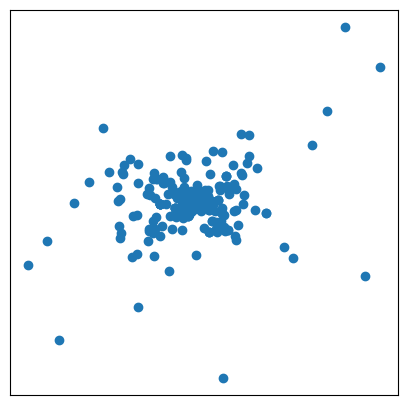

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize = (5, 5))
plt.xticks([]), plt.yticks([])
scat_ = plt.scatter(x = viz_embeddings[:,0], y = viz_embeddings[:,1])

#### Cluster the data points 

In [8]:
fitted_model_ = hdbscan(reduced_embeddings)

In [9]:
labels_ = fitted_model_.labels_ 

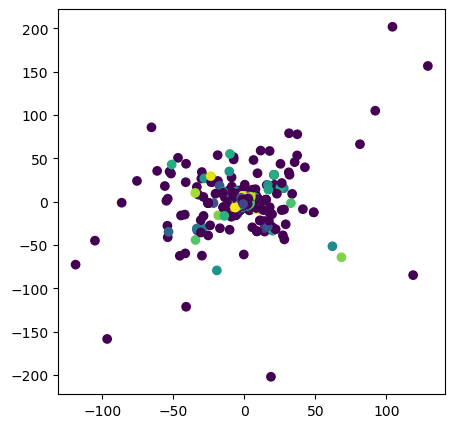

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize = (5, 5))
scat_ = plt.scatter(x = viz_embeddings[:,0], y = viz_embeddings[:,1], c = fitted_model_.labels_)

In [11]:
# Remove the outliers, which are in clusters that are -1. 
# We do not pick the majority cluster in order to prevent topic selection bias.
non_outlier_indices = labels_ != -1

##### Filter out outliers

In [12]:
filtered_embeddings, filtered_documents = reduced_embeddings[non_outlier_indices], documents[non_outlier_indices]

filtered_embeddings.shape, filtered_documents.shape

((132124, 50), (132124,))

#### Save to our vector database

In [22]:
chroma_client.delete_collection(name = "cleaned-msr2013")

In [13]:
try: cleaned_collection = chroma_client.get_collection(name = "msr2013-cleaned")
except: cleaned_collection = chroma_client.create_collection(name="msr2013-cleaned")

In [14]:
import uuid

## Save the version where our embeddings are generated ourselves.

chunk_size = 1_000

for i in range(1 + len(filtered_embeddings) // chunk_size):

    chunked_documents = filtered_documents[i * chunk_size: (i + 1) * chunk_size].tolist()
    chunked_embeddings = filtered_embeddings[i * chunk_size: (i + 1) * chunk_size].tolist()

    cleaned_collection.upsert(
        documents = chunked_documents, 
        embeddings = chunked_embeddings, 
        ids=[f"id-{uuid.uuid4().hex}" for i in range(len(chunked_embeddings))],
    )

In [24]:
chroma_client.delete_collection(name="query-msr2013")

In [25]:
try: msr_ = chroma_client.get_collection(name = "msr2013-query")
except: msr_ = chroma_client.create_collection(name="msr2013-query")

In [26]:
len(set(filtered_documents)), len(filtered_documents)

(131197, 131197)

In [28]:
filtered_documents = [*set([entry.strip().lower() for entry in filtered_documents])]

In [31]:
## Save the raw text

chunk_size = 1_000

for i in range(1 + len(filtered_documents) // chunk_size):

    chunked_documents = filtered_documents[i * chunk_size: (i + 1) * chunk_size]

    msr_.add(
        documents = chunked_documents, 
        ids=[f"id-{uuid.uuid4().hex}" for i in range(len(chunked_documents))],
    )